# **Model Selection**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [14]:
pd.set_option('display.max_colwidth', None)

In [3]:
def create_lstm_model(input_shape, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []

    # Linear Regression with Pipeline
    print('\n\n# Linear Regression')
    pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    params_lr = {
        'regressor__fit_intercept': [True, False],
    }
    model_lr = GridSearchCV(pipeline_lr, params_lr, cv=cv, verbose=verbose)
    result_lr = Model_training(model_lr, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lr, ignore_index=True)

    # Lasso
    print('\n\n# Lasso')
    pipeline_lasso = Pipeline([
        # Uncomment the next line if you want to standardize data for Lasso
        # ('scaler', StandardScaler()),
        ('regressor', Lasso())
    ])
    params_lasso = {
        'regressor__alpha': [0.5, 1],
        'regressor__max_iter': [1000],
        # 'regressor__normalize': [True, False], # Removed since it's deprecated
    }
    model_lasso = GridSearchCV(pipeline_lasso, params_lasso, cv=cv, verbose=verbose)
    result_lasso = Model_training(model_lasso, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lasso, ignore_index=True)

    # Random Forest
    print('\n\n# Random Forest')
    regressor_rf = RandomForestRegressor()
    params_rf = {
    'max_depth': [8, 16, 24],
    'n_estimators': [100, 200],
    'criterion': ['squared_error'],  # Updated from 'mse' to 'squared_error'
    'min_samples_split': [2, 4],
    'max_features': ['sqrt']
    }
    model_rf = GridSearchCV(regressor_rf, params_rf, cv=cv, verbose=verbose)
    result_rf = Model_training(model_rf, X_train, y_train, X_test, y_test, pred_list)
    Results = pd.concat([Results, pd.DataFrame([result_rf])], ignore_index=True)

    print('\n\n# LSTM')
    input_shape = (X_train.shape[1], 1)  # LSTM expects input shape of (time_steps, features)
    regressor_lstm = KerasRegressor(model=lambda: create_lstm_model(input_shape), verbose=0)
    params_lstm = {
        'batch_size': [32, 64],
        'epochs': [50, 100],
        'optimizer': ['adam']
    }
    model_lstm = GridSearchCV(estimator=regressor_lstm, param_grid=params_lstm, cv=cv, verbose=verbose)
    result_lstm = Model_training(model_lstm, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lstm, ignore_index=True)



    Results.index = [model_name[i] for i in range(4)]  # Corrected indexing based on model_name mapping
    return Results, pred_list

def Model_training(model, X_train, y_train, X_test, y_test, pred_list):
    result = {}
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    pred_list.append(np.concatenate((train_pred, test_pred), axis=0))
    result['Train MAE'] = mean_absolute_error(y_train, train_pred)
    result['Train RMSE'] = np.sqrt(mean_squared_error(y_train, train_pred))
    result['Test MAE'] = mean_absolute_error(y_test, test_pred)
    result['Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred))

    return result



model_name = {0: 'Linear Regression', 1: 'Lasso', 2: 'Random Forest', 3: 'LSTM'}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
based_days = 7
next_days = 1
pred_total = {}


# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])

# Without Feature Engineering
print('####### Without Feature Engineering #######')
# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

for trial in range(1, 2):

    print(f'############################################\n\n trial: {trial}\n\n ############################################')

    results_total = []

    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

    print(f'Results {Results}')
    print(f'pred_list {pred_list}')
    results_total.append(Results)

    print('\n\n##################################################\nWithout Feature Engineering')
    print(Results)
    pred_total['Without Feature Engineering'] = pred_list

    # Boruta
    print('\n####### Boruta #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_boruta.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_boruta.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nBoruta')
    print(Results)
    pred_total['Boruta'] = pred_list

    # PCA
    print('\n####### PCA #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_pca.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_pca.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nPCA')
    print(Results)
    pred_total['PCA'] = pred_list

    # t-SNE
    print('\n####### t-SNE #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_tsne.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_tsne.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nt-SNE')
    print(Results)
    pred_total['tSNE'] = pred_list

    # Save Results
    results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

    results_.to_csv(f'./results_{trial}.csv')
    # Visualization
    date = np.concatenate((Train_date, Test_date), axis=0)
    axis_x = np.array(['04-01-2018', '03-01-2019', '02-01-2020', '02-01-2021', '02-01-2022', '01-03-2023', '10-06-2024'])
    y_actual = np.concatenate((y_train, y_test), axis=0)
    plt.rcParams["figure.figsize"] = (10, 8) # Adjust the size as needed
    for key, value in model_name.items():
        ax = plt.subplot(2, 2, key + 1)
        model = key
        ax.set_title(value)
        plt.plot(y_actual, label='Actual')
        for key, value in pred_total.items():
            plt.plot(date, value[model], label=key)
        plt.axvline(linewidth=2, color='r', linestyle='--', x='01-03-2023', ymin=0, ymax=1)
        plt.xticks(axis_x)
        plt.legend()
    #plt.suptitle('Results Comparison (Predicted Day 7)')
    plt.show()
    # plt.rcParams["figure.figsize"] = (20, 20)
    # plt.savefig(f'result_{trial}.png')



####### Without Feature Engineering #######
############################################

 trial: 1

 ############################################


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__f

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1499376863.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1499376863.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)




# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

####### Without Feature Engineering #######
############################################

 trial: 1

 ############################################


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__f

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.1s
[CV] END .....regressor__alpha=0.5, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s
[CV] END .......regressor__alpha=1, regressor__max_iter=1000; total time=   0.0s


/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)




# Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2024-02-12 17:56:55.181078: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-02-12 17:56:55.181116: I metal_plugin/src



# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


2024-02-12 17:56:57.917146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  14.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  14.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  18.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  26.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  29.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  14.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  26.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  35.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  45.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  56.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   7.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   8.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  11.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  14.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  20.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  12.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  17.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  24.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  31.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  37.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)


Results                    Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   1.483713    2.185955   2.103814   2.657183   
Lasso               1.483569    2.214203   1.680404   2.190981   
Random Forest       0.565277    0.846824   9.401563  11.806868   
LSTM                7.074681   13.002431  39.840356  43.090108   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  
LSTM               {'batch_size': 32, 'epochs': 100, 'optimizer':...  
pred_list [array([[ 42.66996931],
       [ 42.97928086],
       [ 43.08370309],
       ...,
       [193.49644393],
       [193.27322842],
       [192.91755568]]), array([ 43.01570071,  43.12845812,  43.30113045, ..., 194.89709684,
       194.3899658 , 194.11892398]), array([ 43.16549942,  43.27784988,  43

/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lasso, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  11.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  17.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  22.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  29.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  36.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  19.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  31.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  43.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  55.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.1min


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   8.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  11.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  16.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  18.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  21.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  12.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  19.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  24.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  31.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  37.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 



##################################################
Boruta
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   1.479221    2.206673   1.814506   2.350119   
Lasso               1.484431    2.221659   1.678116   2.190818   
Random Forest       0.570739    0.865483   9.258024  11.746202   
LSTM                6.943516   12.865917  39.531802  42.830356   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  
LSTM               {'batch_size': 32, 'epochs': 100, 'optimizer':...  

####### PCA #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total ti

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)




# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  11.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  17.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  22.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  28.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  33.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  17.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  30.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  40.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  52.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time= 1.1min


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   9.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  12.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  15.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  18.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  21.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  14.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  19.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  25.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  32.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  37.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lr, ignore_index=True)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 



##################################################
PCA
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression   1.925108    2.693755  75.588110  80.690876   
Lasso               2.077837    2.850734  75.588110  80.643630   
Random Forest       1.081669    1.562043  69.021495  72.736221   
LSTM                6.856163   12.721862  76.526457  80.157694   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  
LSTM               {'batch_size': 32, 'epochs': 100, 'optimizer':...  

####### t-SNE #######


# Linear Regression
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total tim

/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=8, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=16, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END criterion=squared_error, max_depth=24, max_features=sqrt, min_samples_split=4, n_estimators=200; total time=   0.3s


# LSTM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:57: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_rf, ignore_index=True)
/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  13.9s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  19.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  24.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  31.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=32, epochs=50, optimizer=adam; total time=  37.0s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  21.3s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  32.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  43.2s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  50.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=32, epochs=100, optimizer=adam; total time=  53.6s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=   9.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  11.4s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  16.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  16.7s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ...........batch_size=64, epochs=50, optimizer=adam; total time=  18.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  11.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  17.1s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  20.8s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  26.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END ..........batch_size=64, epochs=100, optimizer=adam; total time=  30.5s


/Users/qinglingou/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/var/folders/y5/qp48w1ln6rjgp1z1m108n5t80000gn/T/ipykernel_14028/1439558388.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(result_lstm, ignore_index=True)




##################################################
t-SNE
                   Train MAE  Train RMSE   Test MAE  Test RMSE  \
Linear Regression  12.969487   15.906425  72.819892  77.302222   
Lasso              12.968160   15.907869  72.814629  77.303395   
Random Forest       1.174022    1.689758  74.622520  82.471356   
LSTM                7.438751   12.301267  65.428785  73.171746   

                                                         Best Params  
Linear Regression                 {'regressor__fit_intercept': True}  
Lasso              {'regressor__alpha': 0.5, 'regressor__max_iter...  
Random Forest      {'criterion': 'squared_error', 'max_depth': 24...  
LSTM               {'batch_size': 32, 'epochs': 100, 'optimizer':...  


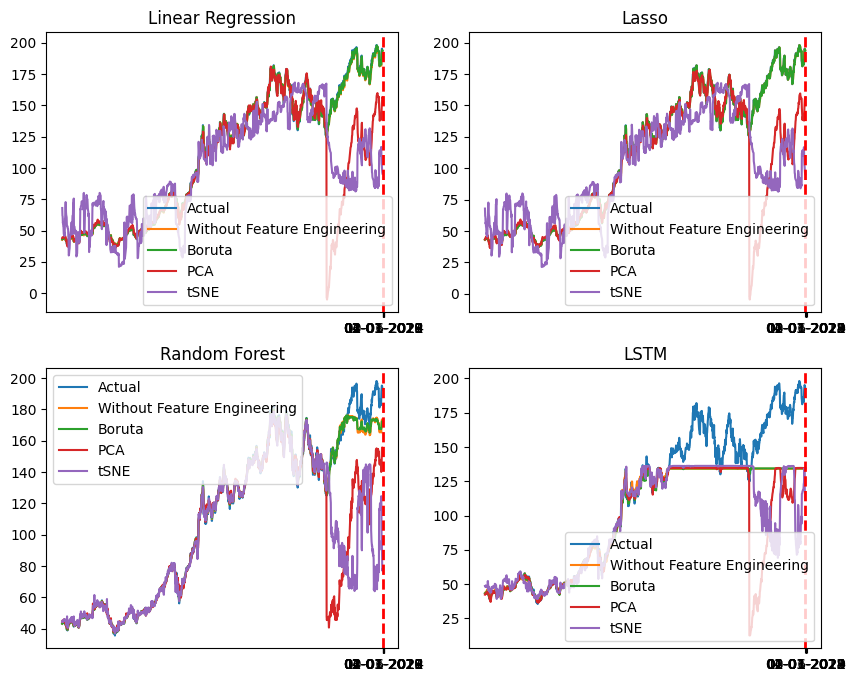

In [5]:


def create_lstm_model(input_shape, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def Model_training(model, X_train, y_train, X_test, y_test, pred_list):
    result = {}
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    pred_list.append(np.concatenate((train_pred, test_pred), axis=0))
    result['Train MAE'] = mean_absolute_error(y_train, train_pred)
    result['Train RMSE'] = np.sqrt(mean_squared_error(y_train, train_pred))
    result['Test MAE'] = mean_absolute_error(y_test, test_pred)
    result['Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred))
    
    if isinstance(model, GridSearchCV):
        result['Best Params'] = model.best_params_
    
    return result

def Multiple_models(X_train, y_train, X_test, y_test, cv, verbose):
    Results = pd.DataFrame(columns=['Train MAE', 'Train RMSE', 'Test MAE', 'Test RMSE'])
    pred_list = []

    print('\n\n# Linear Regression')
    pipeline_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
    ])
    params_lr = {'regressor__fit_intercept': [True, False]}
    model_lr = GridSearchCV(pipeline_lr, params_lr, cv=cv, verbose=verbose)
    result_lr = Model_training(model_lr, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lr, ignore_index=True)

    print('\n\n# Lasso')
    pipeline_lasso = Pipeline([('regressor', Lasso())])
    params_lasso = {'regressor__alpha': [0.5, 1], 'regressor__max_iter': [1000]}
    model_lasso = GridSearchCV(pipeline_lasso, params_lasso, cv=cv, verbose=verbose)
    result_lasso = Model_training(model_lasso, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lasso, ignore_index=True)

    print('\n\n# Random Forest')
    regressor_rf = RandomForestRegressor()
    params_rf = {
        'max_depth': [8, 16, 24],
        'n_estimators': [100, 200],
        'criterion': ['squared_error'],
        'min_samples_split': [2, 4],
        'max_features': ['sqrt']
    }
    model_rf = GridSearchCV(regressor_rf, params_rf, cv=cv, verbose=verbose)
    result_rf = Model_training(model_rf, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_rf, ignore_index=True)

    print('\n\n# LSTM')
    input_shape = (X_train.shape[1], 1)
    regressor_lstm = KerasRegressor(build_fn=lambda: create_lstm_model(input_shape), epochs=100, batch_size=64, verbose=0)
    params_lstm = {'batch_size': [32, 64], 'epochs': [50, 100], 'optimizer': ['adam']}
    model_lstm = GridSearchCV(estimator=regressor_lstm, param_grid=params_lstm, cv=cv, verbose=verbose)
    result_lstm = Model_training(model_lstm, X_train, y_train, X_test, y_test, pred_list)
    Results = Results.append(result_lstm, ignore_index=True)

    Results.index = [model_name[i] for i in range(4)]
    return Results, pred_list




model_name = {0: 'Linear Regression', 1: 'Lasso', 2: 'Random Forest', 3: 'LSTM'}
cv_n_splits = 5
cv = TimeSeriesSplit(n_splits=cv_n_splits)
verbose = 2
based_days = 7
next_days = 1
pred_total = {}


# Pre-Loading
y_train = pd.read_csv("FE results/y_train.csv")
y_train = y_train.drop(columns=['Unnamed: 0'])
y_test = pd.read_csv("FE results/y_test.csv")
y_test = y_test.drop(columns=['Unnamed: 0'])

# Without Feature Engineering
print('####### Without Feature Engineering #######')
# Load Data
X_train = pd.read_csv("FE results/Train_original.csv")
Train_date = X_train['Date']
X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
X_test = pd.read_csv("FE results/Test_original.csv")
Test_date = X_test['Date']
X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])

for trial in range(1, 2):

    print(f'############################################\n\n trial: {trial}\n\n ############################################')

    results_total = []

    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)

    print(f'Results {Results}')
    print(f'pred_list {pred_list}')
    results_total.append(Results)

    print('\n\n##################################################\nWithout Feature Engineering')
    print(Results)
    pred_total['Without Feature Engineering'] = pred_list

    # Boruta
    print('\n####### Boruta #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_boruta.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_boruta.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nBoruta')
    print(Results)
    pred_total['Boruta'] = pred_list

    # PCA
    print('\n####### PCA #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_pca.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_pca.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nPCA')
    print(Results)
    pred_total['PCA'] = pred_list

    # t-SNE
    print('\n####### t-SNE #######')
    # Load Data
    X_train = pd.read_csv('./FE results/Train_tsne.csv')
    X_train = X_train.drop(columns=['Unnamed: 0', 'Date'])
    X_test = pd.read_csv("FE results/Test_tsne.csv")
    X_test = X_test.drop(columns=['Unnamed: 0', 'Date'])
    # Models Training
    Results, pred_list = Multiple_models(X_train, y_train, X_test, y_test, cv, verbose)
    results_total.append(Results)

    print('\n\n##################################################\nt-SNE')
    print(Results)
    pred_total['tSNE'] = pred_list

    # Save Results
    results_ = pd.concat(results_total, keys=['Without FE', 'Boruta', 'PCA', 't-SNE'])

    results_.to_csv(f'./results_{trial}.csv')
    # Visualization
    date = np.concatenate((Train_date, Test_date), axis=0)
    axis_x = np.array(['04-01-2018', '03-01-2019', '02-01-2020', '02-01-2021', '02-01-2022', '01-03-2023', '10-06-2024'])
    y_actual = np.concatenate((y_train, y_test), axis=0)
    plt.rcParams["figure.figsize"] = (10, 8) # Adjust the size as needed
    for key, value in model_name.items():
        ax = plt.subplot(2, 2, key + 1)
        model = key
        ax.set_title(value)
        plt.plot(y_actual, label='Actual')
        for key, value in pred_total.items():
            plt.plot(date, value[model], label=key)
        plt.axvline(linewidth=2, color='r', linestyle='--', x='01-03-2023', ymin=0, ymax=1)
        plt.xticks(axis_x)
        plt.legend()
    #plt.suptitle('Results Comparison (Predicted Day 7)')
    plt.show()


In [15]:
results_

Train MAE  Train RMSE   Test MAE  Test RMSE  \
Without FE Linear Regression   1.483713    2.185955   2.103814   2.657183   
           Lasso               1.483569    2.214203   1.680404   2.190981   
           Random Forest       0.565277    0.846824   9.401563  11.806868   
           LSTM                7.074681   13.002431  39.840356  43.090108   
Boruta     Linear Regression   1.479221    2.206673   1.814506   2.350119   
           Lasso               1.484431    2.221659   1.678116   2.190818   
           Random Forest       0.570739    0.865483   9.258024  11.746202   
           LSTM                6.943516   12.865917  39.531802  42.830356   
PCA        Linear Regression   1.925108    2.693755  75.588110  80.690876   
           Lasso               2.077837    2.850734  75.588110  80.643630   
           Random Forest       1.081669    1.562043  69.021495  72.736221   
           LSTM                6.856163   12.721862  76.526457  80.157694   
t-SNE      Linear Regression  12.969487   15.906425  72.819892  77.302222   
           Lasso              12.968160   15.907869  72.814629  77.303395   
           Random Forest       1.174022    1.689758  74.622520  82.471356   
           LSTM                7.438751   12.301267  65.428785  73.171746   

                                                                                                                                       Best Params  
Without FE Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}  
Boruta     Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}  
PCA        Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}  
t-SNE      Linear Regression                                                                                    {'regressor__fit_intercept': True}  
           Lasso                                                                            {'regressor__alpha': 0.5, 'regressor__max_iter': 1000}  
           Random Forest      {'criterion': 'squared_error', 'max_depth': 24, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}  
           LSTM                                                                             {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam'}